# Step 1: Write Segmentation Algoirthm



In [8]:
import cv2
import numpy as np
from skimage import io, measure
import matplotlib.pyplot as plt

def segleaf(I):
    '''
    Segment a leaf image.
    :param I: Color leaf image to segment.
    :return: Logical image where True pixels represent foreground (i.e. leaf pixels).
    '''
    r, g, b = cv2.split(I)

    lower_green = np.array([0, 50, 0])
    upper_green = np.array([100, 255, 100])

    # Create a mask for pixels within the green color range
    green_mask = cv2.inRange(I, lower_green, upper_green)

    _, binary_image = cv2.threshold(green_mask, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    labeled_image = measure.label(binary_image, connectivity=2)

    # Find region properties, including area
    region_props = measure.regionprops(labeled_image)

    # Find the largest connected component based on area
    largest_region = max(region_props, key=lambda prop: prop.area)

    # Create a mask for the largest component
    leaf_mask = labeled_image == largest_region.label

    return leaf_mask

# Step 2: Implement Segmentation Performace Measures

In [9]:
def shortest_squared_distance(p, B):
    '''
    Shortest squared distance between point p and boundary B
    :param p: a 1x2 array descrbing a 2D point.
    :param B: a Nx2 array of N 2D points.
    :return: shortest squared Euclidean distance between p and B
    '''
    P = np.tile(p, ( B.shape[0], 1) )
    return np.min(np.sum(np.power((P - B),2.0), axis=1))

def msd(A, G):
    '''
    Mean squared distance between two boundaries A and G.
    
    :param A: Nx2 array of boundary points 
    :param G: Mx2 array of boundary points
    :return: the MSD between A and G
    '''

    MSD = 0
    for p in A:
        MSD = MSD + shortest_squared_distance(p,  G)

    return MSD / A.shape[0]


def hd(A, G):
    '''
    Hausdorff distance between two boundaries.
    :param A: Nx2 array of boundary points
    :param G: Mx2 array of boundary points
    :return: Hausdorff distance between the two boundaries.
    '''
    D1 = 0
    for p in A:
        D1 = max(D1, np.sqrt(shortest_squared_distance(p, G)))

    D2 = 0
    for p in G:
        D2 = max(D2, np.sqrt(shortest_squared_distance(p, A)))

    return max(D1, D2)

def dice_coefficient(bwA, bwG):
    '''
    Dice coefficient between two binary images
    :param bwA: a binary (logical) image
    :param bwG: a binary (logical) image
    :return: the Dice coefficient between them
    '''
    intersection = np.logical_and(bwA, bwG)

    return 2.0*np.sum(intersection) / (np.sum(bwA) + np.sum(bwG))

# Step 3: Write a Validation driver program.


In [13]:
import os
import pandas as pd
import numpy as np
from skimage import io
from skimage import segmentation as seg

def get_boundary_points(binary_image):
    bp = np.where(seg.find_boundaries(binary_image > 0, connectivity=2, mode='inner') > 0)
    return np.transpose(np.vstack(bp))

def process_images(images_folder, gt_folder, csv_file):
    image_path = os.path.join('.', images_folder)
    gt_path = os.path.join('.', gt_folder)

    data = pd.read_csv(csv_file, header=None)
    file_names = data[0].tolist()

    MSD_list = []
    HD_list = []
    DSC_list = []
    recognized_list = []

    for file in file_names:
        img = io.imread(os.path.join(image_path, file))

        segmented_img = segleaf(img)

        ground_truth = io.imread(os.path.join(gt_path, file)).astype(bool)

        boundaries_segmented = get_boundary_points(segmented_img)
        boundaries_ground_truth = get_boundary_points(ground_truth)

        MSD_list.append(msd(boundaries_segmented, boundaries_ground_truth))
        HD_list.append(hd(boundaries_segmented, boundaries_ground_truth))
        DSC_list.append(dice_coefficient(segmented_img, ground_truth))

        if DSC_list[-1] >= 0.6:
            recognized_list.append(True)
        else:
            recognized_list.append(False)

        print('Dice coefficient for {}: {}'.format(file, DSC_list[-1]))
        print('Mean square distance for {}: {}'.format(file, MSD_list[-1]))
        print('Hausdorff distance for {}: {}'.format(file, HD_list[-1]))
        print('--------------------------------------------------')

    mean_dice = np.mean(np.array(DSC_list))
    std_dice = np.std(np.array(DSC_list))
    mean_msd = np.mean(np.array(MSD_list))
    std_msd = np.std(np.array(MSD_list))
    mean_hd = np.mean(np.array(HD_list))
    std_hd = np.std(np.array(HD_list))
    recognition_percentage = np.sum(np.array(recognized_list)) / len(recognized_list) * 100

    print('Mean Dice coefficient: {}'.format(mean_dice))
    print('Standard deviation of Dice coefficient: {}'.format(std_dice))
    print('Mean MSD: {}'.format(mean_msd))
    print('Standard deviation of MSD: {}'.format(std_msd))
    print('Mean HD: {}'.format(mean_hd))
    print('Standard deviation of HD: {}'.format(std_hd))
    print('{}% of leaves were recognized.'.format(recognition_percentage))

process_images('images', 'groundtruth', 'images.csv')


DSC for image_0001.png: 0.9987109057374611
MSD for image_0001.png: 0.13507377979568672
HD for image_0001.png: 6.324555320336759
--------------------------------------------------
DSC for image_0002.png: 0.9987594055934627
MSD for image_0002.png: 0.0851565129585998
HD for image_0002.png: 4.0
--------------------------------------------------
DSC for image_0005.png: 0.9987591156100811
MSD for image_0005.png: 0.10686482661004953
HD for image_0005.png: 2.8284271247461903
--------------------------------------------------
DSC for image_0007.png: 0.9982984943721678
MSD for image_0007.png: 17.674113475177304
HD for image_0007.png: 41.012193308819754
--------------------------------------------------
DSC for image_0009.png: 0.9986978422292941
MSD for image_0009.png: 0.4079288625416821
HD for image_0009.png: 12.041594578792296
--------------------------------------------------
DSC for image_0010.png: 0.9989756847059971
MSD for image_0010.png: 0.06259259259259259
HD for image_0010.png: 1.4142135

# Step 4:  Display Examples


Text(0.5, 1.0, 'Bad Result')

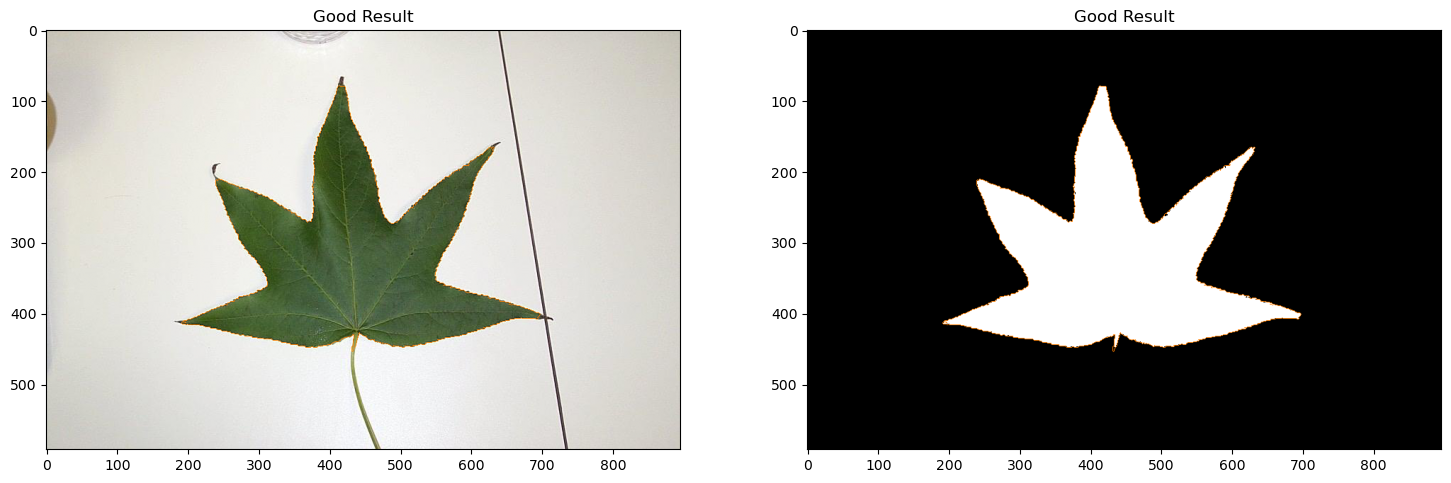

<Figure size 640x480 with 0 Axes>

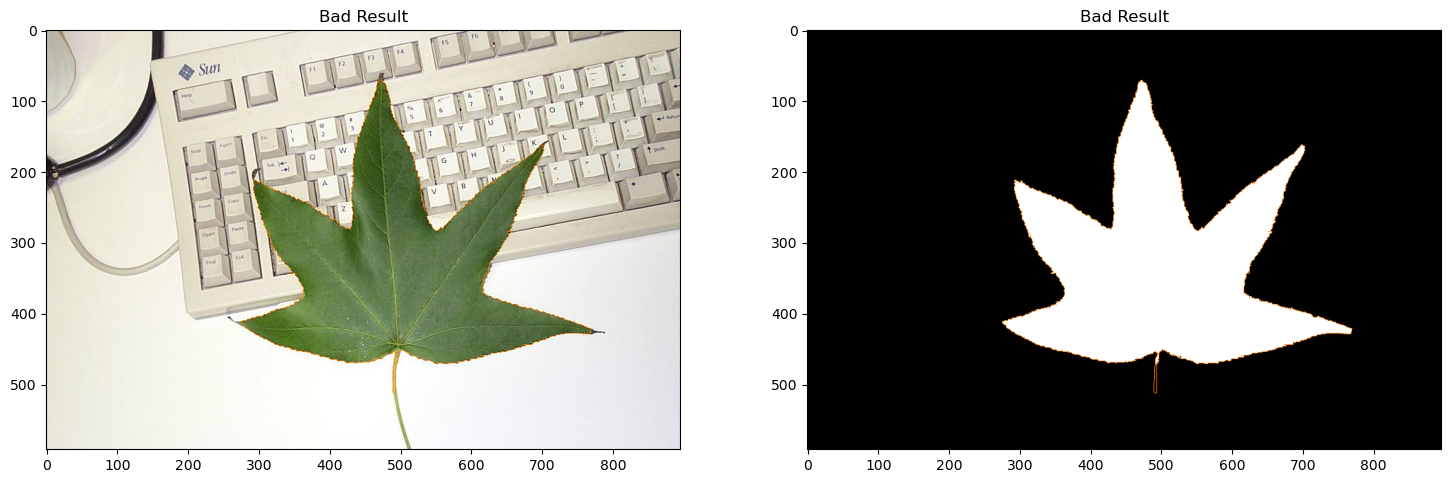

In [16]:
import matplotlib.pyplot as plt

good = io.imread(os.path.join(images_path, 'image_0001.png'))
bad = io.imread(os.path.join(images_path, 'image_0007.png'))
good_gt = io.imread(os.path.join(gt_path, 'image_0001.png'))
bad_gt = io.imread(os.path.join(gt_path, 'image_0007.png'))

good_seg = segleaf(good)
bad_seg = segleaf(bad)

good_label = morph.label(good_seg)
bad_label = morph.label(bad_seg)

plt.subplots(1, 2, figsize=(18,6))
plt.subplot(121)
plt.imshow(seg.mark_boundaries(good, good_label, color=(1,.5,0)))
plt.title('Good Result')
plt.subplot(122)
plt.imshow(seg.mark_boundaries(good_gt, good_label, color=(1,.5,0)))
plt.title('Good Result')

plt.figure()
plt.subplots(1, 2, figsize=(18,6))
plt.subplot(121)
plt.imshow(seg.mark_boundaries(bad, bad_label, color=(1,.5,0)))
plt.title('Bad Result')
plt.subplot(122)
plt.imshow(seg.mark_boundaries(bad_gt, bad_label, color=(1,.5,0)))
plt.title('Bad Result')

# Step 5: A time for reflection.




In [ ]:
"""
The segmentation algorithm converts the input leaf image to the RGB color space and 
defines thresholds for green color, allowing it to create a mask of potentially
green pixels. It then applies Otsu's thresholding to produce a binary image. 
Connected component labeling identifies different regions in the binary image, 
with region properties calculated for each component. The largest connected component 
is considered to be the leaf region, and a binary mask is created to represent it. 
The result is a binary image where True pixels indicate the segmented leaf, effectively
isolating the green leaf region based on color characteristics.

"""

"""
The algorithm primarily relies on color information. Incorporating texture and shape features
into the segmentation process can help distinguish the leaf from the background more effectively,
especially in cases where color alone is insufficient. Additionally, relies on manually defined 
lower and upper bounds for the green color range in the RGB color space. To achieve better results,
a more adaptive or learning-based approach could be implemented to dynamically adjust the color 
range according to the specific characteristics of the input image.

"""

"""
The algorithm is sensitive to variations in lighting conditions. Changes in lighting can 
significantly affect the color representation of the leaf, leading to inaccuracies in 
segmentation. Dark or overexposed regions may not be properly detected. Additionally, the 
leaf can overlap many differrnt object, sometime that object can be green color. This can 
affect a lot to the correction of the detection. The algorithm applies Otsu's thresholding 
method to the green mask without considering adaptive thresholding or techniques to account 
for variations in image contrast. This can lead to incorrect binary segmentation in images
 with varying illumination.
"""